In [ ]:
from theano.sandbox import cuda
cuda.use('gpu1')

In [5]:
%matplotlib inline
import utils; reload(utils)
from utils import *
from __future__ import division, print_function

Using Theano backend.


## Setup

We're going to download the collected works of Nietzsche to use as our data for this class.

In [6]:
path = get_file('nietzsche.txt', origin="https://s3.amazonaws.com/text-datasets/nietzsche.txt")
text = open(path).read()
print('corpus length:', len(text))

corpus length: 600901


In [7]:
chars = sorted(list(set(text)))
vocab_size = len(chars)+1
print('total chars:', vocab_size)

total chars: 86


Sometimes it's useful to have a zero value in the dataset, e.g. for padding

In [8]:
chars.insert(0, "\0")

In [9]:
''.join(chars[1:-6])

'\n !"\'(),-.0123456789:;=?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]_abcdefghijklmnopqrstuvwxyz'

Map from chars to indices and back again

In [10]:
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

*idx* will be the data we use from now own - it simply converts all the characters to their index (based on the mapping above)

In [11]:
idx = [char_indices[c] for c in text]

In [12]:
idx[:10]

[40, 42, 29, 30, 25, 27, 29, 1, 1, 1]

In [13]:
''.join(indices_char[i] for i in idx[:70])

'PREFACE\n\n\nSUPPOSING that Truth is a woman--what then? Is there not gro'

## 3 char model

### Create inputs

Create a list of every 4th character, starting at the 0th, 1st, 2nd, then 3rd characters

In [14]:
cs=3
c1_dat = [idx[i] for i in xrange(0, len(idx)-1-cs, cs)]
c2_dat = [idx[i+1] for i in xrange(0, len(idx)-1-cs, cs)]
c3_dat = [idx[i+2] for i in xrange(0, len(idx)-1-cs, cs)]
c4_dat = [idx[i+3] for i in xrange(0, len(idx)-1-cs, cs)]

Our inputs

In [15]:
x1 = np.stack(c1_dat[:-2])
x2 = np.stack(c2_dat[:-2])
x3 = np.stack(c3_dat[:-2])

Our output

In [16]:
y = np.stack(c4_dat[:-2])

The first 4 inputs and outputs

In [17]:
x1[:4], x2[:4], x3[:4]

(array([40, 30, 29,  1]), array([42, 25,  1, 43]), array([29, 27,  1, 45]))

In [18]:
y[:4]

array([30, 29,  1, 40])

In [19]:
x1.shape, y.shape

((200297,), (200297,))

The number of latent factors to create (i.e. the size of the embedding matrix)

In [20]:
n_fac = 42

Create inputs and embedding outputs for each of our 3 character inputs

In [21]:
def embedding_input(name, n_in, n_out):
    inp = Input(shape=(1,), dtype='int64', name=name)
    emb = Embedding(n_in, n_out, input_length=1)(inp)
    return inp, Flatten()(emb)

In [22]:
c1_in, c1 = embedding_input('c1', vocab_size, n_fac)
c2_in, c2 = embedding_input('c2', vocab_size, n_fac)
c3_in, c3 = embedding_input('c3', vocab_size, n_fac)

### Create and train model

Pick a size for our hidden state

In [23]:
n_hidden = 256

This is the 'green arrow' from our diagram - the layer operation from input to hidden.

In [24]:
dense_in = Dense(n_hidden, activation='relu')

Our first hidden activation is simply this function applied to the result of the embedding of the first character.

In [25]:
c1_hidden = dense_in(c1)

This is the 'orange arrow' from our diagram - the layer operation from hidden to hidden.

In [26]:
dense_hidden = Dense(n_hidden, activation='tanh')

Our second and third hidden activations sum up the previous hidden state (after applying dense_hidden) to the new input state.

In [27]:
c2_dense = dense_in(c2)
hidden_2 = dense_hidden(c1_hidden)
c2_hidden = merge([c2_dense, hidden_2])

In [28]:
c3_dense = dense_in(c3)
hidden_3 = dense_hidden(c2_hidden)
c3_hidden = merge([c3_dense, hidden_3])

This is the 'blue arrow' from our diagram - the layer operation from hidden to output.

In [29]:
dense_out = Dense(vocab_size, activation='softmax')

The third hidden state is the input to our output layer.

In [30]:
c4_out = dense_out(c3_hidden)

In [31]:
model = Model([c1_in, c2_in, c3_in], c4_out)

In [32]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam())

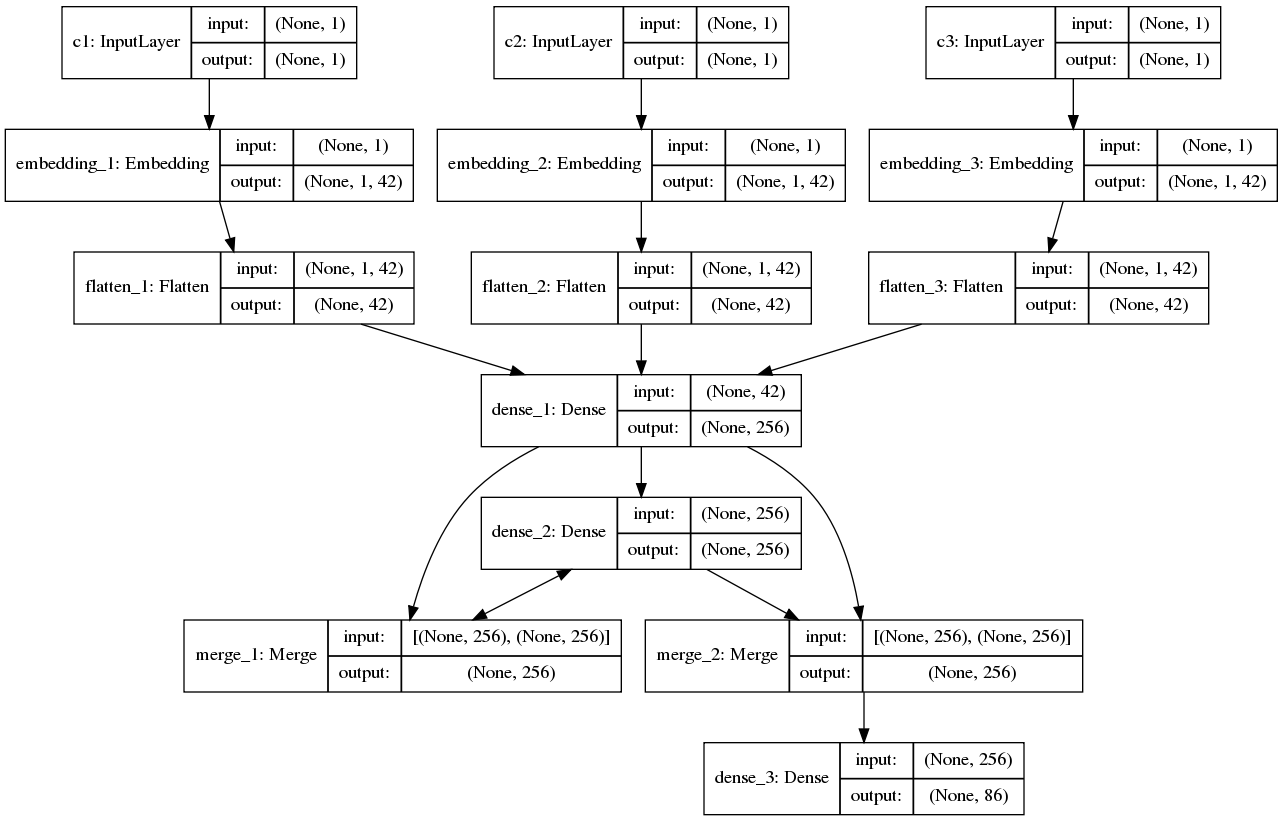

In [34]:
from keras.utils.visualize_util import plot
plot(model, to_file='nn.png', show_shapes=True)
from IPython.display import Image
Image(filename='nn.png')

In [ ]:
model.optimizer.lr=0.000001

In [ ]:
model.fit([x1, x2, x3], y, batch_size=64, nb_epoch=4)

In [100]:
model.optimizer.lr=0.01

In [ ]:
model.fit([x1, x2, x3], y, batch_size=64, nb_epoch=4)

Epoch 1/4
 82752/200297 [===========>..................] - ETA: 13s - loss: 2.9170

In [94]:
model.optimizer.lr = 0.000001

In [ ]:
model.fit([x1, x2, x3], y, batch_size=64, nb_epoch=4)

Epoch 1/4
 68032/200297 [=========>....................] - ETA: 14s - loss: 2.9523

In [88]:
model.optimizer.lr = 0.01

In [ ]:
model.fit([x1, x2, x3], y, batch_size=64, nb_epoch=4)

Epoch 1/4
 80576/200297 [===========>..................] - ETA: 13s - loss: 2.9823

### Test model

In [102]:
def get_next(inp):
    idxs = [char_indices[c] for c in inp]
    arrs = [np.array(i)[np.newaxis] for i in idxs]
    p = model.predict(arrs)
    i = np.argmax(p)
    return chars[i]

In [103]:
get_next('phi')

' '

In [104]:
get_next(' th')

'e'

In [105]:
get_next(' an')

' '

## Our first RNN!

### Create inputs

This is the size of our unrolled RNN.

In [ ]:
cs=8

For each of 0 through 7, create a list of every 8th character with that starting point. These will be the 8 inputs to out model.

In [ ]:
c_in_dat = [[idx[i+n] for i in xrange(0, len(idx)-1-cs, cs)]
            for n in range(cs)]

Then create a list of the next character in each of these series. This will be the labels for our model.

In [ ]:
c_out_dat = [idx[i+cs] for i in xrange(0, len(idx)-1-cs, cs)]

In [ ]:
xs = [np.stack(c[:-2]) for c in c_in_dat]

In [ ]:
len(xs), xs[0].shape

In [ ]:
y = np.stack(c_out_dat[:-2])

So each column below is one series of 8 characters from the text.

In [ ]:
[xs[n][:cs] for n in range(cs)]

...and this is the next character after each sequence.

In [ ]:
y[:cs]

In [ ]:
n_fac = 42

### Create and train model

In [ ]:
def embedding_input(name, n_in, n_out):
    inp = Input(shape=(1,), dtype='int64', name=name+'_in')
    emb = Embedding(n_in, n_out, input_length=1, name=name+'_emb')(inp)
    return inp, Flatten()(emb)

In [ ]:
c_ins = [embedding_input('c'+str(n), vocab_size, n_fac) for n in range(cs)]

In [ ]:
n_hidden = 256

In [ ]:
dense_in = Dense(n_hidden, activation='relu')
dense_hidden = Dense(n_hidden, activation='relu', init='identity')
dense_out = Dense(vocab_size, activation='softmax')

The first character of each sequence goes through dense_in(), to create our first hidden activations.

In [ ]:
hidden = dense_in(c_ins[0][1])

Then for each successive layer we combine the output of dense_in() on the next character with the output of dense_hidden() on the current hidden state, to create the new hidden state.

In [ ]:
for i in range(1,cs):
    c_dense = dense_in(c_ins[i][1])
    hidden = dense_hidden(hidden)
    hidden = merge([c_dense, hidden])

Putting the final hidden state through dense_out() gives us our output.

In [ ]:
c_out = dense_out(hidden)

So now we can create our model.

In [ ]:
model = Model([c[0] for c in c_ins], c_out)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam())

In [ ]:
model.fit(xs, y, batch_size=64, nb_epoch=12)

### Test model

In [ ]:
def get_next(inp):
    idxs = [np.array(char_indices[c])[np.newaxis] for c in inp]
    p = model.predict(idxs)
    return chars[np.argmax(p)]

In [ ]:
get_next('for thos')

In [ ]:
get_next('part of ')

In [ ]:
get_next('queens a')

## Our first RNN with keras!

In [ ]:
n_hidden, n_fac, cs, vocab_size = (256, 42, 8, 86)

This is nearly exactly equivalent to the RNN we built ourselves in the previous section.

In [ ]:
model=Sequential([
        Embedding(vocab_size, n_fac, input_length=cs),
        SimpleRNN(n_hidden, activation='relu', inner_init='identity'),
        Dense(vocab_size, activation='softmax')
    ])

In [ ]:
model.summary()

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam())

In [ ]:
model.fit(np.stack(xs,1), y, batch_size=64, nb_epoch=8)

In [ ]:
def get_next_keras(inp):
    idxs = [char_indices[c] for c in inp]
    arrs = np.array(idxs)[np.newaxis,:]
    p = model.predict(arrs)[0]
    return chars[np.argmax(p)]

In [ ]:
get_next_keras('this is ')

In [ ]:
get_next_keras('part of ')

In [ ]:
get_next_keras('queens a')

## Returning sequences

### Create inputs

To use a sequence model, we can leave our input unchanged - but we have to change our output to a sequence (of course!)

Here, c_out_dat is identical to c_in_dat, but moved across 1 character.

In [ ]:
#c_in_dat = [[idx[i+n] for i in xrange(0, len(idx)-1-cs, cs)]
#            for n in range(cs)]
c_out_dat = [[idx[i+n] for i in xrange(1, len(idx)-cs, cs)]
            for n in range(cs)]

In [ ]:
ys = [np.stack(c[:-2]) for c in c_out_dat]

Reading down each column shows one set of inputs and outputs.

In [ ]:
[xs[n][:cs] for n in range(cs)]

In [ ]:
[ys[n][:cs] for n in range(cs)]

### Create and train model

In [ ]:
dense_in = Dense(n_hidden, activation='relu')
dense_hidden = Dense(n_hidden, activation='relu', init='identity')
dense_out = Dense(vocab_size, activation='softmax', name='output')

We're going to pass a vector of all zeros as our starting point - here's our input layers for that:

In [ ]:
inp1 = Input(shape=(n_fac,), name='zeros')
hidden = dense_in(inp1)

In [ ]:
outs = []

for i in range(cs):
    c_dense = dense_in(c_ins[i][1])
    hidden = dense_hidden(hidden)
    hidden = merge([c_dense, hidden], mode='sum')
    # every layer now has an output
    outs.append(dense_out(hidden))

In [ ]:
model = Model([inp1] + [c[0] for c in c_ins], outs)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam())

In [ ]:
zeros = np.tile(np.zeros(n_fac), (len(xs[0]),1))
zeros.shape

In [ ]:
model.fit([zeros]+xs, ys, batch_size=64, nb_epoch=12)

### Test model

In [ ]:
def get_nexts(inp):
    idxs = [char_indices[c] for c in inp]
    arrs = [np.array(i)[np.newaxis] for i in idxs]
    p = model.predict([np.zeros(n_fac)[np.newaxis,:]] + arrs)
    print(list(inp))
    return [chars[np.argmax(o)] for o in p]

In [ ]:
get_nexts(' this is')

In [ ]:
get_nexts(' part of')

### Sequence model with keras

In [ ]:
n_hidden, n_fac, cs, vocab_size

To convert our previous keras model into a sequence model, simply add the 'return_sequences=True' parameter, and add TimeDistributed() around our dense layer.

In [ ]:
model=Sequential([
        Embedding(vocab_size, n_fac, input_length=cs),
        SimpleRNN(n_hidden, return_sequences=True, activation='relu', inner_init='identity'),
        TimeDistributed(Dense(vocab_size, activation='softmax')),
    ])

In [ ]:
model.summary()

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam())

In [ ]:
xs[0].shape

In [ ]:
x_rnn=np.stack(xs, axis=1)
y_rnn=np.expand_dims(np.stack(ys, axis=1), -1)

In [ ]:
x_rnn.shape, y_rnn.shape

In [ ]:
model.fit(x_rnn, y_rnn, batch_size=64, nb_epoch=8)

In [ ]:
def get_nexts_keras(inp):
    idxs = [char_indices[c] for c in inp]
    arr = np.array(idxs)[np.newaxis,:]
    p = model.predict(arr)[0]
    print(list(inp))
    return [chars[np.argmax(o)] for o in p]

In [ ]:
get_nexts_keras(' this is')

### One-hot sequence model with keras

This is the keras version of the theano model that we're about to create.

In [ ]:
model=Sequential([
        SimpleRNN(n_hidden, return_sequences=True, input_shape=(cs, vocab_size),
                  activation='relu', inner_init='identity'),
        TimeDistributed(Dense(vocab_size, activation='softmax')),
    ])
model.compile(loss='categorical_crossentropy', optimizer=Adam())

In [ ]:
oh_ys = [to_categorical(o, vocab_size) for o in ys]
oh_y_rnn=np.stack(oh_ys, axis=1)

oh_xs = [to_categorical(o, vocab_size) for o in xs]
oh_x_rnn=np.stack(oh_xs, axis=1)

oh_x_rnn.shape, oh_y_rnn.shape

In [ ]:
model.fit(oh_x_rnn, oh_y_rnn, batch_size=64, nb_epoch=8)

In [ ]:
def get_nexts_oh(inp):
    idxs = np.array([char_indices[c] for c in inp])
    arr = to_categorical(idxs, vocab_size)
    p = model.predict(arr[np.newaxis,:])[0]
    print(list(inp))
    return [chars[np.argmax(o)] for o in p]

In [ ]:
get_nexts_oh(' this is')

## Stateful model with keras

In [ ]:
bs=64

A stateful model is easy to create (just add "stateful=True") but harder to train. We had to add batchnorm and use LSTM to get reasonable results.

When using stateful in keras, you have to also add 'batch_input_shape' to the first layer, and fix the batch size there.

In [ ]:
model=Sequential([
        Embedding(vocab_size, n_fac, input_length=cs, batch_input_shape=(bs,8)),
        BatchNormalization(),
        LSTM(n_hidden, return_sequences=True, stateful=True),
        TimeDistributed(Dense(vocab_size, activation='softmax')),
    ])

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam())

Since we're using a fixed batch shape, we have to ensure our inputs and outputs are a even multiple of the batch size.

In [ ]:
mx = len(x_rnn)//bs*bs

In [ ]:
model.fit(x_rnn[:mx], y_rnn[:mx], batch_size=bs, nb_epoch=4, shuffle=False)

In [ ]:
model.optimizer.lr=1e-4

In [ ]:
model.fit(x_rnn[:mx], y_rnn[:mx], batch_size=bs, nb_epoch=4, shuffle=False)

In [ ]:
model.fit(x_rnn[:mx], y_rnn[:mx], batch_size=bs, nb_epoch=4, shuffle=False)

## Theano RNN

In [ ]:
n_input = vocab_size
n_output = vocab_size

Using raw theano, we have to create our weight matrices and bias vectors ourselves - here are the functions we'll use to do so (using glorot initialization).

The return values are wrapped in `shared()`, which is how we tell theano that it can manage this data (copying it to and from the GPU as necessary).

In [ ]:
def init_wgts(rows, cols): 
    scale = math.sqrt(2/rows)
    return shared(normal(scale=scale, size=(rows, cols)).astype(np.float32))
def init_bias(rows): 
    return shared(np.zeros(rows, dtype=np.float32))

We return the weights and biases together as a tuple. For the hidden weights, we'll use an identity initialization (as recommended by [Hinton](https://arxiv.org/abs/1504.00941).)

In [ ]:
def wgts_and_bias(n_in, n_out): 
    return init_wgts(n_in, n_out), init_bias(n_out)
def id_and_bias(n): 
    return shared(np.eye(n, dtype=np.float32)), init_bias(n)

Theano doesn't actually do any computations until we explicitly compile and evaluate the function (at which point it'll be turned into CUDA code and sent off to the GPU). So our job is to describe the computations that we'll want theano to do - the first step is to tell theano what inputs we'll be providing to our computation:

In [ ]:
t_inp = T.matrix('inp')
t_outp = T.matrix('outp')
t_h0 = T.vector('h0')
lr = T.scalar('lr')

all_args = [t_h0, t_inp, t_outp, lr]

Now we're ready to create our intial weight matrices.

In [ ]:
W_h = id_and_bias(n_hidden)
W_x = wgts_and_bias(n_input, n_hidden)
W_y = wgts_and_bias(n_hidden, n_output)
w_all = list(chain.from_iterable([W_h, W_x, W_y]))

Theano handles looping by using the [GPU scan](http://http.developer.nvidia.com/GPUGems3/gpugems3_ch39.html) operation. We have to tell theano what to do at each step through the scan - this is the function we'll use, which does a single forward pass for one character:

In [ ]:
def step(x, h, W_h, b_h, W_x, b_x, W_y, b_y):
    # Calculate the hidden activations
    h = nnet.relu(T.dot(x, W_x) + b_x + T.dot(h, W_h) + b_h)
    # Calculate the output activations
    y = nnet.softmax(T.dot(h, W_y) + b_y)
    # Return both (the 'Flatten()' is to work around a theano bug)
    return h, T.flatten(y, 1)

Now we can provide everything necessary for the scan operation, so we can setup that up - we have to pass in the function to call at each step, the sequence to step through, the initial values of the outputs, and any other arguments to pass to the step function.

In [ ]:
[v_h, v_y], _ = theano.scan(step, sequences=t_inp, 
                            outputs_info=[t_h0, None], non_sequences=w_all)

We can now calculate our loss function, and *all* of our gradients, with just a couple of lines of code!

In [ ]:
error = nnet.categorical_crossentropy(v_y, t_outp).sum()
g_all = T.grad(error, w_all)

We even have to show theano how to do SGD - so we set up this dictionary of updates to complete after every forward pass, which apply to standard SGD update rule to every weight.

In [ ]:
def upd_dict(wgts, grads, lr): 
    return OrderedDict({w: w-g*lr for (w,g) in zip(wgts,grads)})

upd = upd_dict(w_all, g_all, lr)

We're finally ready to compile the function!

In [ ]:
fn = theano.function(all_args, error, updates=upd, allow_input_downcast=True)

In [ ]:
X = oh_x_rnn
Y = oh_y_rnn
X.shape, Y.shape

To use it, we simply loop through our input data, calling the function compiled above, and printing our progress from time to time.

In [ ]:
err=0.0; l_rate=0.01
for i in range(len(X)): 
    err+=fn(np.zeros(n_hidden), X[i], Y[i], l_rate)
    if i % 1000 == 999: 
        print ("Error:{:.3f}".format(err/1000))
        err=0.0

In [ ]:
f_y = theano.function([t_h0, t_inp], v_y, allow_input_downcast=True)

In [ ]:
pred = np.argmax(f_y(np.zeros(n_hidden), X[6]), axis=1)

In [ ]:
act = np.argmax(X[6], axis=1)

In [ ]:
[indices_char[o] for o in act]

In [ ]:
[indices_char[o] for o in pred]

## Pure python RNN!

### Set up basic functions

Now we're going to try to repeat the above theano RNN, using just pure python (and numpy). Which means, we have to do everything ourselves, including defining the basic functions of a neural net! Below are all of the definitions, along with tests to check that they give the same answers as theano. The functions ending in `_d` are the derivatives of each function.

In [ ]:
def sigmoid(x): return 1/(1+np.exp(-x))
def sigmoid_d(x): 
    output = sigmoid(x)
    return output*(1-output)

In [ ]:
def relu(x): return np.maximum(0., x)
def relu_d(x): return (x > 0.)*1.

In [ ]:
relu(np.array([3.,-3.])), relu_d(np.array([3.,-3.]))

In [ ]:
def dist(a,b): return pow(a-b,2)
def dist_d(a,b): return 2*(a-b)

In [ ]:
import pdb

In [ ]:
eps = 1e-7
def x_entropy(pred, actual): 
    return -np.sum(actual * np.log(np.clip(pred, eps, 1-eps)))
def x_entropy_d(pred, actual): return -actual/pred

In [ ]:
def softmax(x): return np.exp(x)/np.exp(x).sum()

In [ ]:
def softmax_d(x):
    sm = softmax(x)
    res = np.expand_dims(-sm,-1)*sm
    res[np.diag_indices_from(res)] = sm*(1-sm)
    return res

In [ ]:
test_preds = np.array([0.2,0.7,0.1])
test_actuals = np.array([0.,1.,0.])
nnet.categorical_crossentropy(test_preds, test_actuals).eval()

In [ ]:
x_entropy(test_preds, test_actuals)

In [ ]:
test_inp = T.dvector()
test_out = nnet.categorical_crossentropy(test_inp, test_actuals)
test_grad = theano.function([test_inp], T.grad(test_out, test_inp))

In [ ]:
test_grad(test_preds)

In [ ]:
x_entropy_d(test_preds, test_actuals)

In [ ]:
pre_pred = random(oh_x_rnn[0][0].shape)
preds = softmax(pre_pred)
actual = oh_x_rnn[0][0]

In [ ]:
np.allclose(softmax_d(pre_pred).dot(loss_d(preds,actual)), preds-actual)

In [ ]:
softmax(test_preds)

In [ ]:
nnet.softmax(test_preds).eval()

In [ ]:
test_out = T.flatten(nnet.softmax(test_inp))

In [ ]:
test_grad = theano.function([test_inp], theano.gradient.jacobian(test_out, test_inp))

In [ ]:
test_grad(test_preds)

In [ ]:
softmax_d(test_preds)

In [ ]:
act=relu
act_d = relu_d

In [ ]:
loss=x_entropy
loss_d=x_entropy_d

We also have to define our own scan function. Since we're not worrying about running things in parallel, it's very simple to implement:

In [ ]:
def scan(fn, start, seq):
    res = []
    prev = start
    for s in seq:
        app = fn(prev, s)
        res.append(app)
        prev = app
    return res

...for instance, `scan` on `+` is the cumulative sum.

In [ ]:
scan(lambda prev,curr: prev+curr, 0, range(5))

### Set up training

Let's now build the functions to do the forward and backward passes of our RNN. First, define our data and shape.

In [ ]:
inp = oh_x_rnn
outp = oh_y_rnn
n_input = vocab_size
n_output = vocab_size

In [ ]:
inp.shape, outp.shape

Here's the function to do a single forward pass of an RNN, for a single character.

In [ ]:
def one_char(prev, item):
    # Previous state
    tot_loss, pre_hidden, pre_pred, hidden, ypred = prev
    # Current inputs and output
    x, y = item
    pre_hidden = np.dot(x,w_x) + np.dot(hidden,w_h)
    hidden = act(pre_hidden)
    pre_pred = np.dot(hidden,w_y)
    ypred = softmax(pre_pred)
    return (
        # Keep track of loss so we can report it
        tot_loss+loss(ypred, y),
        # Used in backprop
        pre_hidden, pre_pred, 
        # Used in next iteration
        hidden, 
        # To provide predictions
        ypred)

We use `scan` to apply the above to a whole sequence of characters.

In [ ]:
def get_chars(n): return zip(inp[n], outp[n])
def one_fwd(n): return scan(one_char, (0,0,0,np.zeros(n_hidden),0), get_chars(n))

Now we can define the backward step. We use a loop to go through every element of the sequence. The derivatives are applying the chain rule to each step, and accumulating the gradients across the sequence.

In [ ]:
# "Columnify" a vector
def col(x): return x[:,newaxis]

def one_bkwd(args, n):
    global w_x,w_y,w_h

    i=inp[n]  # 8x86
    o=outp[n] # 8x86
    d_pre_hidden = np.zeros(n_hidden) # 256
    for p in reversed(range(len(i))):
        totloss, pre_hidden, pre_pred, hidden, ypred = args[p]
        x=i[p] # 86
        y=o[p] # 86
        d_pre_pred = softmax_d(pre_pred).dot(loss_d(ypred,y))  # 86
        d_pre_hidden = (np.dot(d_pre_hidden, w_h.T) 
                        + np.dot(d_pre_pred,w_y.T)) * act_d(pre_hidden) # 256

        # d(loss)/d(w_y) = d(loss)/d(pre_pred) * d(pre_pred)/d(w_y)
        w_y -= col(hidden) * d_pre_pred * alpha
        # d(loss)/d(w_h) = d(loss)/d(pre_hidden[p-1]) * d(pre_hidden[p-1])/d(w_h)
        if (p>0): w_h -= args[p-1][3].dot(d_pre_hidden) * alpha
        w_x -= col(x)*d_pre_hidden * alpha
    return d_pre_hidden

Now we can set up our initial weight matrices. Note that we're not using bias at all in this example, in order to keep things simpler.

In [ ]:
scale=math.sqrt(2./n_input)
w_x = normal(scale=scale, size=(n_input,n_hidden))
w_y = normal(scale=scale, size=(n_hidden, n_output))
w_h = np.eye(n_hidden, dtype=np.float32)

Our loop looks much like the theano loop in the previous section, except that we have to call the backwards step ourselves.

In [ ]:
overallError=0
alpha=0.0001
for n in range(10000):
    res = one_fwd(n)
    overallError+=res[-1][0]
    deriv = one_bkwd(res, n)
    if(n % 1000 == 999):
        print ("Error:{:.4f}; Gradient:{:.5f}".format(
                overallError/1000, np.linalg.norm(deriv)))
        overallError=0

## Keras GRU

Identical to the last keras rnn, but a GRU!

In [ ]:
model=Sequential([
        GRU(n_hidden, return_sequences=True, input_shape=(cs, vocab_size),
                  activation='relu', inner_init='identity'),
        TimeDistributed(Dense(vocab_size, activation='softmax')),
    ])
model.compile(loss='categorical_crossentropy', optimizer=Adam())

In [ ]:
model.fit(oh_x_rnn, oh_y_rnn, batch_size=64, nb_epoch=8)

In [ ]:
get_nexts_oh(' this is')

## Theano GRU

### Separate weights

The theano GRU looks just like the simple theano RNN, except for the use of the reset and update gates. Each of these gates requires its own hidden and input weights, so we add those to our weight matrices.

In [ ]:
W_h = id_and_bias(n_hidden)
W_x = init_wgts(n_input, n_hidden)
W_y = wgts_and_bias(n_hidden, n_output)
rW_h = init_wgts(n_hidden, n_hidden)
rW_x = wgts_and_bias(n_input, n_hidden)
uW_h = init_wgts(n_hidden, n_hidden)
uW_x = wgts_and_bias(n_input, n_hidden)
w_all = list(chain.from_iterable([W_h, W_y, uW_x, rW_x]))
w_all.extend([W_x, uW_h, rW_h])

Here's the definition of a gate - it's just a sigmoid applied to the addition of the dot products of the input vectors.

In [ ]:
def gate(x, h, W_h, W_x, b_x):
    return nnet.sigmoid(T.dot(x, W_x) + b_x + T.dot(h, W_h))

Our step is nearly identical to before, except that we multiply our hidden state by our reset gate, and we update our hidden state based on the update gate.

In [ ]:
def step(x, h, W_h, b_h, W_y, b_y, uW_x, ub_x, rW_x, rb_x, W_x, uW_h, rW_h):
    reset = gate(x, h, rW_h, rW_x, rb_x)
    update = gate(x, h, uW_h, uW_x, ub_x)
    h_new = gate(x, h * reset, W_h, W_x, b_h)
    h = update*h + (1-update)*h_new
    y = nnet.softmax(T.dot(h, W_y) + b_y)
    return h, T.flatten(y, 1)

Everything from here on is identical to our simple RNN in theano.

In [ ]:
[v_h, v_y], _ = theano.scan(step, sequences=t_inp, 
                            outputs_info=[t_h0, None], non_sequences=w_all)

In [ ]:
error = nnet.categorical_crossentropy(v_y, t_outp).sum()
g_all = T.grad(error, w_all)

In [ ]:
upd = upd_dict(w_all, g_all, lr)
fn = theano.function(all_args, error, updates=upd, allow_input_downcast=True)

In [ ]:
err=0.0; l_rate=0.1
for i in range(len(X)): 
    err+=fn(np.zeros(n_hidden), X[i], Y[i], l_rate)
    if i % 1000 == 999: 
        l_rate *= 0.95
        print ("Error:{:.2f}".format(err/1000))
        err=0.0

### Combined weights

We can make the previous section simpler and faster by concatenating the hidden and input matrices and inputs together. We're not going to step through this cell by cell - you'll see it's identical to the previous section except for this concatenation.

In [ ]:
W = (shared(np.concatenate([np.eye(n_hidden), normal(size=(n_input, n_hidden))])
            .astype(np.float32)), init_bias(n_hidden))

rW = wgts_and_bias(n_input+n_hidden, n_hidden)
uW = wgts_and_bias(n_input+n_hidden, n_hidden)
W_y = wgts_and_bias(n_hidden, n_output)
w_all = list(chain.from_iterable([W, W_y, uW, rW]))

In [ ]:
def gate(m, W, b): return nnet.sigmoid(T.dot(m, W) + b)

In [ ]:
def step(x, h, W, b, W_y, b_y, uW, ub, rW, rb):
    m = T.concatenate([h, x])
    reset = gate(m, rW, rb)
    update = gate(m, uW, ub)
    m = T.concatenate([h*reset, x])
    h_new = gate(m, W, b)
    h = update*h + (1-update)*h_new
    y = nnet.softmax(T.dot(h, W_y) + b_y)
    return h, T.flatten(y, 1)

In [ ]:
[v_h, v_y], _ = theano.scan(step, sequences=t_inp, 
                            outputs_info=[t_h0, None], non_sequences=w_all)

In [ ]:
def upd_dict(wgts, grads, lr): 
    return OrderedDict({w: w-g*lr for (w,g) in zip(wgts,grads)})

In [ ]:
error = nnet.categorical_crossentropy(v_y, t_outp).sum()
g_all = T.grad(error, w_all)

In [ ]:
upd = upd_dict(w_all, g_all, lr)
fn = theano.function(all_args, error, updates=upd, allow_input_downcast=True)

In [ ]:
err=0.0; l_rate=0.01
for i in range(len(X)): 
    err+=fn(np.zeros(n_hidden), X[i], Y[i], l_rate)
    if i % 1000 == 999: 
        print ("Error:{:.2f}".format(err/1000))
        err=0.0

### End